In [11]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import numpy as np
from selenium import webdriver
import chromedriver_autoinstaller
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.support.ui import WebDriverWait
import pickle

In [12]:
# To install latest version of chromedriver
chromedriver_autoinstaller.install()

'C:\\Users\\nimod\\anaconda3\\envs\\geo_env\\lib\\site-packages\\chromedriver_autoinstaller\\112\\chromedriver.exe'

In [13]:
# Structure des données


In [14]:
class trail:
    def __init__(self,nom_id,d,s,hd,csv):
        self.nom_id = nom_id 
        self.date = d
        self.suivi = s
        self.heure_depart =hd
        self.csv_file =csv
        
    def load_ppassage_csv(self):
        self.df_ppassage = pd.read_csv(f'./data/{self.csv_file}',sep=',')
        self.df_ppassage.loc[0,'Delta_reel_h']=0.0
        self.df_ppassage.loc[0,'Delta_Dist_km']=0
        self.df_ppassage.loc[0,'Delta_D+_m']=0
        for i in range(len(self.df_ppassage)-1):
            self.df_ppassage.loc[i+1,'Delta_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h']-self.df_ppassage.loc[i,'H_reel_h']
            self.df_ppassage.loc[i+1,'Delta_Dist_km']=self.df_ppassage.loc[i+1,'Cumul_Dist_km']-self.df_ppassage.loc[i,'Cumul_Dist_km']
            self.df_ppassage.loc[i+1,'Delta_D+_m']=self.df_ppassage.loc[i+1,'Cumul_D+_m']-self.df_ppassage.loc[i,'Cumul_D+_m']
        # display(self.df_ppassage)
        print(f'CSV File loaded under {self.nom_id}.df_ppassage')
    
    def remove_missing(self): # Elimine les empty cell et corrige s'il manque une heure de passage 
        if self.df_ppassage['Heure_Passage'].isnull().values.any():
            print('Il y a une heure de passage manquante',self.df_ppassage[self.df_ppassage['Heure_Passage'].isnull()]['Point_passage'])
            self.df_ppassage=self.df_ppassage.dropna(axis=0,subset=['Heure_Passage']).reset_index(drop=True)
            for i in range(1,len(self.df_ppassage)):             
                self.df_ppassage.loc[i,'Delta_Dist_km']=self.df_ppassage.loc[i,'Cumul_Dist_km']-self.df_ppassage.loc[i-1,'Cumul_Dist_km']
                self.df_ppassage.loc[i,'Delta_D+_m']=self.df_ppassage.loc[i,'Cumul_D+_m']-self.df_ppassage.loc[i-1,'Cumul_D+_m'] 
    
    def load_gpx(self, file):
        with open(file) as f:
            data=f.read().strip()
            data_parse =data.split('<trkpt')
            #utb_lst_elev = []
            parcours=[]
            for p in data_parse[1:]:
                pt={}
                try:
                    pt['alt'] = int(re.findall('<ele>(.+?)</ele>',p)[0])
                except:
                    pt['alt']='NA'
                pt['lat'] = float(re.findall('"(.+?)"',p)[0])
                pt['lon'] = float(re.findall('"(.+?)"',p)[1])
                parcours.append(pt)
        self.df_parcours = pd.DataFrame(parcours)
        print(f'gpx File loaded under {self.nom_id}.df_parcours')
         
    def load_data_livetrail(self,url): # Format heure depart XX:XX:XX
        coureur ='morand romain'
        # install chrome web driver https://sites.google.com/a/chromium.org/chromedriver/downloads
        PATH = "C:\Program Files\chromedriver.exe"
        driver = webdriver.Chrome(PATH)
        driver.get(url)
        time.sleep(1)
        inputElement = driver.find_element(By.NAME, "rech")
        inputElement.send_keys(coureur)
        inputElement.submit()
        time.sleep(2)
        tableau = driver.find_element(By.XPATH, '//*[@id="fc"]/div[3]/div[2]/a[1]')
        tableau.click()
        txt = driver.page_source
        txt = txt.replace('&nbsp;','').replace('\n','').replace('\t','')
        time.sleep(2)
        driver.close()
        # Extract 
        inter = re.findall('idpt:(.+?){',txt,re.DOTALL)
        table =[]
        for l in inter:
            point={}
            #print(l)
            point['id']= int(re.findall("'(.+?)',kmt",l,re.DOTALL)[0])
            point['Point_passage']=re.findall('n:"(.+?)"',l,re.DOTALL)[0]
            point['Altitude_m']=int(re.findall("a:'(.+?) m'",l,re.DOTALL)[0].replace(' ',''))
            point['Cumul_Dist_km']=float(re.findall("kmt:'(.+?) km'",l,re.DOTALL)[0].replace(',','.'))
            if 'NaN' in re.findall("kmp:'(.+?) km'",l,re.DOTALL)[0]:
                point['Delta_Dist_km']=0.0
            else:
                point['Delta_Dist_km']=float(re.findall("kmp:'(.+?) km'",l,re.DOTALL)[0].replace(',','.'))
            point['Cumul_D+_m']=int(re.findall("dt:'(.+?) m'",l,re.DOTALL)[0].replace(' ',''))
            try: point['Delta_D+_m']=int(re.findall("dp:'(.+?) m'",l,re.DOTALL)[0].replace(' ','')) 
            except: point['Delta_D+_m']=0
            point['lon']=float(re.findall("lon:'(.+?)'",l,re.DOTALL)[0])
            point['lat']=float(re.findall("lat:'(.+?)'",l,re.DOTALL)[0])
            try: point['Heure_Passage']=(re.findall("hp:'(.+?)',tc",l,re.DOTALL)[0])
            except: point['Heure_Passage']=''
            try: point['Temps_course']=(re.findall("tc:'(.+?)',clt",l,re.DOTALL)[0])
            except: point['Temps_course']=''
            try: point['Classement']=(re.findall("clt:'(.+?)',vit",l,re.DOTALL)[0])
            except: point['Classement']=''
            try: point['Vitesse_km/h']=float(re.findall("vit:'(.+?)km/h'",l,re.DOTALL)[0].replace(',','.')) 
            except: point['Vitesse_km/h']=0
            #print(point)
            table.append(point)
        self.df_ppassage=pd.DataFrame(table)
        # Conversion des données
        for i in range(len(self.df_ppassage)):
            try:
                self.df_ppassage.loc[i,'H_reel_h']=int(self.df_ppassage.loc[i,'Temps_course'].split(':')[0])+int(self.df_ppassage.loc[i,'Temps_course'].split(':')[1])/60+int(self.df_ppassage.loc[i,'Temps_course'].split(':')[2])/60/60
            except:
                 self.df_ppassage.loc[i,'H_reel_h']=0
        self.df_ppassage.loc[0,'Delta_reel_h']=0
        for i in range(len(self.df_ppassage)-1):
            self.df_ppassage.loc[i+1,'Delta_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h']-self.df_ppassage.loc[i,'H_reel_h']
        # Enregistrement
        self.csv_file = self.date+"_"+re.findall('Romain MORAND-(.+?)- Live',txt,re.DOTALL)[0].strip()+"_"+str(self.df_ppassage.loc[len(self.df_ppassage)-1,'Cumul_Dist_km'])+"km.csv"
        self.df_ppassage.to_csv(f'./data/{self.csv_file}', index=False)
        print('Livetrail data loaded under XXX.df_ppassage and .csv file')
    
    def load_data_before_livetrack(self, url): # # Format heure depart XX:XX:XX
        # install chrome web driver https://sites.google.com/a/chromium.org/chromedriver/downloads
        PATH = "C:\Program Files\chromedriver.exe"
        driver = webdriver.Chrome(PATH)
        driver.get(url)
        time.sleep(1)
        txt = driver.page_source
        time.sleep(2)
        driver.close()
        # Extract 
        inter = re.findall('<tbody>(.+?)</tbody>',txt,re.DOTALL)[0]
        inter2 = re.findall('<tr (.+?)</tr>',inter,re.DOTALL)
        table =[]
        for l in inter2:
            point={}
            # print(l)
            point['id']= int(re.findall('class="sequenceNumber">(.+?)</span>',l,re.DOTALL)[0])
            point['Point_passage']=re.findall('class="stationName">(.+?)</span>',l,re.DOTALL)[0]

            point['Delta_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ',''))
            point['Cumul_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[1].replace('k','').replace('m','').replace(' ',''))
            
            if 'km' in re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0]:
                point['Delta_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ',''))
            else:
                point['Delta_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[0].replace('k','').replace('m','').replace(' ',''))/1000
                
            point['Cumul_Dist_km']=float(re.findall('class="right aligned separated">(.+?)</td>',l,re.DOTALL)[1].replace('k','').replace('m','').replace(' ',''))
            
            point['Delta_D+_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[0].replace('+ ',''))
            point['Delta_D-_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[1].replace('- ',''))

            point['Cumul_D+_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[2].replace('+ ',''))
            point['Cumul_D-_m']=int(re.findall('class="right aligned">D(.+?) m</td>',l,re.DOTALL)[3].replace('- ',''))#     except: point['Delta_D+_m']=0

            Missing_info = '"sequence_number":'+str(point['id'])+'(.+?){"id":'
            new_l=re.findall(Missing_info,txt,re.DOTALL)[0]
            point['lon']=float(re.findall('gps_longitude":(.+?),"gps',new_l,re.DOTALL)[0])
            point['lat']=float(re.findall('gps_latitude":(.+?),"gps',new_l,re.DOTALL)[0])
            point['Altitude_m']=int(float(re.findall('gps_elevation":(.+?),"is_public"',new_l,re.DOTALL)[0]))
            table.append(point)
        table
        self.df_ppassage=pd.DataFrame(table)
        # self.df_ppassage.loc[0,'Heure_Passage']=self.heure_depart
        # for i in range(len(self.df_ppassage)):
        #     try:
        #         self.df_ppassage.loc[i,'H_reel_h']=int(self.df_ppassage.loc[i,'Temps_course'].split(':')[0])+int(self.df_ppassage.loc[i,'Temps_course'].split(':')[1])/60+int(self.df_ppassage.loc[i,'Temps_course'].split(':')[2])/60/60
        #     except:
        #          self.df_ppassage.loc[i,'H_reel_h']=0
        # # Enregistrement
        self.csv_file = self.date+"_"+re.findall('LiveTrack(.+?)-',txt,re.DOTALL)[0].replace('|','').strip()+"_"+str(self.df_ppassage.loc[len(self.df_ppassage)-1,'Cumul_Dist_km'])+"km.csv"
        self.df_ppassage.to_csv(f'./data/{self.csv_file}', index=False)
        print('Livetrail data loaded under XXX.df_ppassage and .csv file')    
    
    def load_data_after_livetrack(self, url): # 
        print('Vérifier que la method .load_data_before_livetrack a déjà été exécutée')
        coureur ='romain-morand' 
        url = url.replace('course','coureur')+'-'+coureur
        # install chrome web driver https://sites.google.com/a/chromium.org/chromedriver/downloads
        PATH = "C:\Program Files\chromedriver.exe"
        driver = webdriver.Chrome(PATH)
        driver.get(url)
        time.sleep(1)
        # Chargement des données avec temps de passage par défaut
        txt = driver.page_source   
        time.sleep(2)
        # Extract 
        inter = re.findall('<tbody>(.+?)</tbody>',txt,re.DOTALL)[0]
        inter2 = re.findall('<tr (.+?)</tr>',inter,re.DOTALL)
        table =[]
        for l in inter2:
            point={}
            # print(l)
            point['id']= int(re.findall('class="sequenceNumber">(.+?)</span>',l,re.DOTALL)[0])
            point['Point_passage']=re.findall('class="stationName">(.+?)</span>',l,re.DOTALL)[0]
            infos = re.findall('class="center aligned">(.+?)</td>',l,re.DOTALL)[0].split('/')
            # if 'km' in infos[0]:
            #     point['Cumul_Dist_km']=float(infos[0].replace('km',''))
            # else:
            #     point['Cumul_Dist_km']=float(infos[0].replace('m',''))/1000
            # point['Cumul_D+_m']=float(infos[1].replace('D+','').replace('m',''))
            try: point['Heure_Passage']=re.findall('<span class="timestamp">(.+?)</span>',l,re.DOTALL)[0]
            except: point['Heure_Passage']=''
            if 'Pause' in l:
                point['Temps_pause']=re.findall('<span class="timestamp">(.+?)</span>',l,re.DOTALL)[1]
            try: point['Classement']=(re.findall('<span class="ranking">(.+?)</span>',l,re.DOTALL)[0])
            except: point['Classement']=''
            table.append(point)
        df=pd.DataFrame(table)
        # Switch pour les temps de course au lieu du temps de passage
        checkbox = driver.find_elements(By.XPATH, "//label[@for='showRaceTimes']")
        print(checkbox)
        checkbox[0].click()
        time.sleep(1)
        txt = driver.page_source 
        time.sleep(1)
        # Extract 
        inter = re.findall('<tbody>(.+?)</tbody>',txt,re.DOTALL)[0]
        inter2 = re.findall('<tr (.+?)</tr>',inter,re.DOTALL)
        table2 =[]
        for l in inter2:
            point={}
            point['Point_passage']=re.findall('class="stationName">(.+?)</span>',l,re.DOTALL)[0]
            try:point['Temps_course']=re.findall('<span class="timestamp">(.+?)</span>',l,re.DOTALL)[0]     
            except: point['Temps_course']=''
            table2.append(point)
        df2=pd.DataFrame(table2)
        df= pd.merge(df,df2,on='Point_passage',how='left')
        #
        for i in range(len(df)):
            try:
                df.loc[i,'H_reel_h']=int(df.loc[i,'Temps_course'].split(':')[0])+int(df.loc[i,'Temps_course'].split(':')[1])/60+int(df.loc[i,'Temps_course'].split(':')[2])/60/60
            except:
                 df.loc[i,'H_reel_h']=0  
        self.df_ppassage=pd.merge(self.df_ppassage,df,on='Point_passage',how='left')
        # Enregistrement
        titre = re.findall('<title>(.+?)</title>',txt,re.DOTALL)[0]
        self.csv_file = self.date+"_"+re.findall('-(.+?)-',titre,re.DOTALL)[0].replace('|','').strip()+"_"+str(self.df_ppassage.loc[len(self.df_ppassage)-1,'Cumul_Dist_km'])+"km.csv"
        self.df_ppassage.to_csv(f'./data/{self.csv_file}', index=False)
        print('Livetrail data loaded under XXX.df_ppassage and .csv file')    
        driver.close()
    
    def arret(self, durée_stop, à_partir_de):
        self.df_ppassage['H_reel_h_init']=self.df_ppassage['H_reel_h']
        for i in range(len(self.df_ppassage)-1):
            if self.df_ppassage.loc[i+1,'H_reel_h']>à_partir_de:
                self.df_ppassage.loc[i+1,'H_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h_init']-durée_stop
            else: 
                self.df_ppassage.loc[i+1,'H_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h']
        # On recalcule de DeltaT
        self.df_ppassage['Delta_reel_h_init']=self.df_ppassage['Delta_reel_h']
        for i in range(len(self.df_ppassage)-1):
            self.df_ppassage.loc[i+1,'Delta_reel_h']=self.df_ppassage.loc[i+1,'H_reel_h']-self.df_ppassage.loc[i,'H_reel_h']
        

https://www.livetrack.me/fr/evenement/ultratour-du-beaufortain/edition/utb-2022/coureur/utb-2022-solos-romain-morand
https://www.livetrack.me/fr/evenement/ultratour-du-beaufortain/edition/utb-2022/course/utb-2022-solos

# Liste des trails réalisés

### Chargement des nouveaux tracés à partir du tableau de synthèse

In [15]:
Lst_trails = pd.read_csv('ListeDesTrails.csv',sep=',')
Lst_trails

,Trail,Date,Suivi,Heure_depart,Lien_URL,Fichier_parcours_gpx,Vit_plat_km/h,Vit_den+_m/h,Csv_file,Date_dt
0,20195REFUGES,2019-07-28,livetrail,07:30:00,https://livetrail.net/histo/fiz_2019/coureur.php,NaN,10.0,1229.8,2019-07-28_5ref_31.7km.csv,2019-07-28
1,2019MCC,2019-08-26,livetrail,10:00:00,https://livetrail.net/histo/utmb_2019/coureur.php,tracedetrail_94254.gpx,6.9,2933.5,2019-08-26_MCC_39.1km.csv,2019-08-26
2,2020GTC,2020-09-13,livetrail,06:00:00,https://livetrail.net/histo/serreche_2020/cour...,NaN,7.0,1314.0,2020-09-13_GTC_56.5km.csv,2020-09-13
3,20218REFUGES,2021-07-25,livetrail,05:00:00,https://fiz.livetrail.net/coureur.php,tracedetrail_156428.gpx,8.4,1217.6,2021-07-25_Tour des 8 refuges Evadict_65.1km.csv,2021-07-25
4,2021DOOBLE,2021-07-31,livetrail,08:00:00,https://megevenaturetrail.livetrail.run/coureu...,NaN,13.5,1643.0,2021-07-31_LA DOOBLE - 16 KM_17.9km.csv,2021-07-31
5,2021TRAVNORD,2021-08-21,livetrail,05:15:00,https://echappeebelle.livetrail.run/parcours....,tracedetrail_135447.gpx,5.2,2137.3,2021-08-21_Traversée Nord_83.4km.csv,2021-08-21
6,2022UTHG,2022-06-17,livetrail,23:45:00,https://ultratrailduhautgiffre.livetrail.run/c...,tracedetrail_166975.gpx,6.0,1283.3,2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv,2022-06-17
7,2022MBM,2022-06-25,livetrail,08:00:00,https://mbm.livetrail.run/coureur.php,23km-2022.gpx,14.3,882.0,2022-06-24_23km du Mont-Blanc_24.4km.csv,2022-06-25
8,2022UTB,2022-07-16,livetrack,04:00:00,https://www.livetrack.me/fr/evenement/ultratou...,ultra_tour_du_beaufortain_2022-13673263-165493...,5.4,1177.4,2022-07-16_Ultra Tour du Beaufortain 2022_114....,2022-07-16
9,2023UTLAC,2023-06-16,livetrail,19:00:00,https://ultratrailduhautgiffre.livetrail.run/c...,tracedetrail_189127.gpx,NaN,NaN,NaN,NaN


### Creation des objets trails

In [16]:
Trails_objects = [trail(n.Trail,n.Date,n.Suivi,n.Heure_depart,n.Csv_file) for idx,n in Lst_trails.iterrows()]
for i,T in enumerate(Trails_objects):
    print(i,T.nom_id,T.date,T.suivi,T.heure_depart,T.csv_file)

0 20195REFUGES 2019-07-28 livetrail 07:30:00 2019-07-28_5ref_31.7km.csv
1 2019MCC 2019-08-26 livetrail 10:00:00 2019-08-26_MCC_39.1km.csv
2 2020GTC 2020-09-13 livetrail 06:00:00 2020-09-13_GTC_56.5km.csv
3 20218REFUGES 2021-07-25 livetrail 05:00:00 2021-07-25_Tour des 8 refuges Evadict_65.1km.csv
4 2021DOOBLE 2021-07-31 livetrail 08:00:00 2021-07-31_LA DOOBLE - 16 KM_17.9km.csv
5 2021TRAVNORD 2021-08-21 livetrail 05:15:00 2021-08-21_Traversée Nord_83.4km.csv
6 2022UTHG 2022-06-17 livetrail  23:45:00 2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv
7 2022MBM 2022-06-25 livetrail 08:00:00 2022-06-24_23km du Mont-Blanc_24.4km.csv
8 2022UTB 2022-07-16 livetrack 04:00:00 2022-07-16_Ultra Tour du Beaufortain 2022_114.0km.csv
9 2023UTLAC 2023-06-16 livetrail 19:00:00 nan


### Chargement des points de passage et des parcrours, Si pas de csv alors connexion au site

In [17]:
for i,T in enumerate(Trails_objects):
    # Chargement des points de passage
    if T.suivi == 'livetrail' and pd.isnull(T.csv_file):
        T.load_data_livetrail(Lst_trails.loc[Lst_trails['Trail']==T.nom_id,'Lien_URL'].values[0])
        Lst_trails.loc[Lst_trails['Trail']==T.nom_id,'Csv_file']=T.csv_file
        print(i, T.nom_id,T.date,T.suivi,T.heure_depart)
    elif T.suivi == 'livetrack' and pd.isnull(T.csv_file):
        txt = T.load_data_before_livetrack(Lst_trails.loc[Lst_trails['Trail']==T.nom_id,'Lien_URL'].values[0])
        Lst_trails.loc[Lst_trails['Trail']==T.nom_id,'Csv_file']=T.csv_file
        print(i,T.nom_id,T.date,T.suivi,T.heure_depart)
    else:
        T.load_ppassage_csv()
    # Chargement des points de parcours
    if pd.notnull(Lst_trails.Fichier_parcours_gpx[i]):
        T.load_gpx(f'./data/{Lst_trails.Fichier_parcours_gpx[i]}')

CSV File loaded under 20195REFUGES.df_ppassage
CSV File loaded under 2019MCC.df_ppassage
gpx File loaded under 2019MCC.df_parcours
CSV File loaded under 2020GTC.df_ppassage
CSV File loaded under 20218REFUGES.df_ppassage
gpx File loaded under 20218REFUGES.df_parcours
CSV File loaded under 2021DOOBLE.df_ppassage
CSV File loaded under 2021TRAVNORD.df_ppassage
gpx File loaded under 2021TRAVNORD.df_parcours
CSV File loaded under 2022UTHG.df_ppassage
gpx File loaded under 2022UTHG.df_parcours
CSV File loaded under 2022MBM.df_ppassage
gpx File loaded under 2022MBM.df_parcours
CSV File loaded under 2022UTB.df_ppassage
gpx File loaded under 2022UTB.df_parcours


C:\Users\nimod\AppData\Local\Temp\ipykernel_2956\992560459.py:51: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(PATH)


SessionNotCreatedException: Message: session not created: This version of ChromeDriver only supports Chrome version 107
Current browser version is 112.0.5615.139 with binary path C:\Program Files\Google\Chrome\Application\chrome.exe
Stacktrace:
Backtrace:
	Ordinal0 [0x011FACD3+2075859]
	Ordinal0 [0x0118EE61+1633889]
	Ordinal0 [0x0108B7BD+571325]
	Ordinal0 [0x010ADFCD+712653]
	Ordinal0 [0x010A9266+692838]
	Ordinal0 [0x010A6BE9+682985]
	Ordinal0 [0x010DDBD3+908243]
	Ordinal0 [0x010DD6AA+906922]
	Ordinal0 [0x010D7136+880950]
	Ordinal0 [0x010AFEFD+720637]
	Ordinal0 [0x010B0F3F+724799]
	GetHandleVerifier [0x014AEED2+2769538]
	GetHandleVerifier [0x014A0D95+2711877]
	GetHandleVerifier [0x0128A03A+521194]
	GetHandleVerifier [0x01288DA0+516432]
	Ordinal0 [0x0119682C+1665068]
	Ordinal0 [0x0119B128+1683752]
	Ordinal0 [0x0119B215+1683989]
	Ordinal0 [0x011A6484+1729668]
	BaseThreadInitThunk [0x76937D49+25]
	RtlInitializeExceptionChain [0x7700B74B+107]
	RtlClearBits [0x7700B6CF+191]


### Creation de la version avec Arret et Creation du trail All_trails, somme de tous les segments

In [100]:
durée_arret = 1.25
à_partir_de = 13

df = pd.DataFrame()
for T in Trails_objects:
    # T.load_ppassage_csv()
    T.remove_missing()
    T.arret(durée_arret,à_partir_de)
    if pd.to_datetime(T.date)<=datetime.datetime.now():
        print(T.nom_id,T.date,T.suivi,T.heure_depart,T.csv_file)
        T.remove_missing() # Elimine les lignes manquantes et recalcule le temps si il y a des trous
        # T.arret(durée_arret,à_partir_de)
        T.df_ppassage['Trail']=T.nom_id
        df = pd.concat([df,T.df_ppassage])
df=df.reset_index(drop=True) # reset index in df

20195REFUGES 2019-07-28 livetrail 07:30:00 2019-07-28_5ref_31.7km.csv
2019MCC 2019-08-26 livetrail 10:00:00 2019-08-26_MCC_39.1km.csv
2020GTC 2020-09-13 livetrail 06:00:00 2020-09-13_GTC_56.5km.csv
20218REFUGES 2021-07-25 livetrail 05:00:00 2021-07-25_Tour des 8 refuges Evadict_65.1km.csv
2021DOOBLE 2021-07-31 livetrail 08:00:00 2021-07-31_LA DOOBLE - 16 KM_17.9km.csv
2021TRAVNORD 2021-08-21 livetrail 05:15:00 2021-08-21_Traversée Nord_83.4km.csv
2022UTHG 2022-06-17 livetrail  23:45:00 2022-06-17_Ultra-Trail® du haut-Giffre_97.4km.csv
Il y a une heure de passage manquante 2    Montroc
Name: Point_passage, dtype: object
2022MBM 2022-06-25 livetrail 08:00:00 2022-06-24_23km du Mont-Blanc_24.4km.csv
Il y a une heure de passage manquante 27    La Journée
33        Queige
Name: Point_passage, dtype: object
2022UTB 2022-07-16 livetrack 04:00:00 2022-07-16_Ultra Tour du Beaufortain 2022_114.0km.csv


In [101]:
All_trails=trail('All', '1979-12-05', 'NA','NA','NA') # nom_id,d,s,hd,csv)
All_trails.df_ppassage = df

Nombre de segments: 91
      pour une distance totale de: 529.5 km
      pour un dénivelé total   de: 35837 m  


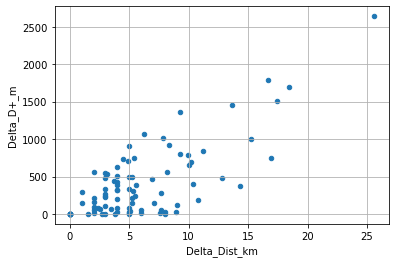

In [102]:
# Affiche tous les segments
print(f"""Nombre de segments: {len(All_trails.df_ppassage)}
      pour une distance totale de: {All_trails.df_ppassage['Delta_Dist_km'].sum()} km
      pour un dénivelé total   de: {All_trails.df_ppassage['Delta_D+_m'].sum()} m  """)
All_trails.df_ppassage.plot.scatter('Delta_Dist_km','Delta_D+_m')
plt.grid()

In [103]:
All_trails.df_ppassage[['Trail','Point_passage','Heure_Passage','Temps_course','H_reel_h_init','H_reel_h','Delta_reel_h_init','Delta_reel_h']]

,Trail,Point_passage,Heure_Passage,Temps_course,H_reel_h_init,H_reel_h,Delta_reel_h_init,Delta_reel_h
0,20195REFUGES,Plaine Joux,Di. 07:28,00:00:00,0.000000,0.000000,0.000000,0.000000
1,20195REFUGES,Refuge Alfred Wills,Di. 10:39,03:11:00,3.183333,3.183333,3.183333,3.183333
2,20195REFUGES,Fontaine Ayere,Di. 12:01,04:32:43,4.545278,4.545278,1.361944,1.361944
3,20195REFUGES,Refuge du Châlet d'Ayères,Di. 12:14,04:46:15,4.770833,4.770833,0.225556,0.225556
4,20195REFUGES,Plaine Joux,Di. 12:30,05:01:51,5.030833,5.030833,0.260000,0.260000
...,...,...,...,...,...,...,...,...
86,2022UTB,Les Jorets,03:53:57,23:53:08,23.885556,22.635556,1.132500,1.132500
87,2022UTB,Les Saisies - Office du Tourisme,04:45:42,24:44:53,24.748056,23.498056,0.862500,0.862500
88,2022UTB,Le Lata du Vaz,06:01:29,26:00:40,26.011111,24.761111,1.263056,1.263056
89,2022UTB,Plan des Maisons,06:54:35,26:53:46,26.896111,25.646111,0.885000,0.885000


### Save Trails in pickle file

In [104]:
PIK = "trails.dat"
with open(PIK, "wb") as f:
    for T in Trails_objects:
        pickle.dump(T, f)
    pickle.dump(All_trails, f)
print('Task completed')

Task completed


In [105]:
Trails_objects[8].df_ppassage

,id_x,Point_passage,Delta_Dist_km,Cumul_Dist_km,Delta_D+_m,Delta_D-_m,Cumul_D+_m,Cumul_D-_m,lon,lat,...,id_y,Heure_Passage,Classement,Temps_pause,Temps_course,H_reel_h,Delta_reel_h,H_reel_h_init,Delta_reel_h_init,Trail
0,1,Départ,0.0,0.0,0,0,0,0,6.45826,45.71642,...,1,04:00:49,NaN,NaN,-,0.000000,0.000000,0.000000,0.000000,2022UTB
1,2,Gîte de Molliessoulaz,4.0,4.0,422,18,422,18,6.46178,45.70777,...,2,04:44:29,288.0,NaN,00:43:40,0.727778,0.727778,0.727778,0.727778,2022UTB
2,3,Les Chappes,3.0,7.0,476,1,898,19,6.45347,45.69656,...,3,05:21:02,294.0,NaN,01:20:13,1.336944,0.609167,1.336944,0.609167,2022UTB
3,4,Frêtte basse,2.0,9.0,555,7,1453,26,6.46982,45.68290,...,4,06:09:26,298.0,NaN,02:08:37,2.143611,0.806667,2.143611,0.806667,2022UTB
4,5,Col des Lacs,4.0,13.0,318,113,1771,139,6.49444,45.66374,...,5,06:53:42,293.0,NaN,02:52:53,2.881389,0.737778,2.881389,0.737778,2022UTB
5,6,Chalet du Soufflet,3.0,16.0,6,423,1777,562,6.51137,45.65223,...,6,07:16:23,284.0,(10 min),03:15:34,3.259444,0.378056,3.259444,0.378056,2022UTB
6,7,Ardoisière de Cevins,2.0,18.0,214,63,1991,624,6.51010,45.63713,...,7,07:56:40,318.0,NaN,03:55:51,3.930833,0.671389,3.930833,0.671389,2022UTB
7,8,Col des Combettes,3.0,21.0,263,108,2254,732,6.52981,45.64957,...,8,08:37:22,314.0,NaN,04:36:33,4.609167,0.678333,4.609167,0.678333,2022UTB
8,9,Col des Bonnets rouges,4.0,25.0,198,286,2452,1019,6.56261,45.65310,...,9,09:22:21,303.0,NaN,05:21:32,5.358889,0.749722,5.358889,0.749722,2022UTB
9,10,Lac de St Guerin,5.0,30.0,13,462,2465,1481,6.58220,45.64175,...,10,10:02:31,290.0,NaN,06:01:42,6.028333,0.669444,6.028333,0.669444,2022UTB
